In [ ]:

#torch.cuda.empty_cache() # free cuda memory to avoid cuda out of mem
#!pip install GPUtil

import torch, gc
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             
    gc.collect()
    
    #del device
    torch.cuda.empty_cache()

    print("\nGPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

In [ ]:
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
#@title Specify parameters before running


SZ =  1 #@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

BATCH_SZ =  32 #@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

EPOCHS =  2 #@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

# Indicate to clean data or not. Used in Data Cleaning section
CLEAN = False  #@param {type:"boolean"}
DATA = "Synthetic-Ftp" #@param {type:"string"}



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

%matplotlib inline

#import nltk
#nltk.download("popular")

## Tokenizing syscall sequences into n-grams of 6
#from nltk.tokenize import word_tokenize
#from nltk import ngrams

## **Load pre-processed data**

In [5]:
#from google.colab import files
#files.upload()

import os
dir = 'Processed-Data/'
data_dir = dir+DATA
os.listdir(data_dir)

['old',
 'result',
 'saved_models',
 'Synthetic-Ftp-Duplication-test.zip',
 'test',
 'test_clean.csv',
 'test_unclean.csv',
 'train.csv.gz',
 'train_clean.csv']

In [6]:
# Read in data
if CLEAN:   x_train = pd.read_csv(data_dir+'/train_clean.csv', header = 0)
else:       x_train = pd.read_csv(data_dir+'/train.csv.gz', header = 0, compression = 'gzip')
test_clean = pd.read_csv(data_dir+'/test_clean.csv', header = 0)
test_unclean = pd.read_csv(data_dir+'/test_unclean.csv', header = 0)


In [7]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Label
0,4,6,13,13,107,107,107,106,5,55,...,89,89,89,89,89,89,89,89,89,0
1,106,3,27,107,10,107,107,107,106,5,...,89,89,89,89,89,89,89,89,89,0
2,4,3,4,3,4,3,4,3,4,3,...,4,3,4,3,4,3,4,3,4,0
3,3,4,3,4,3,4,3,4,3,4,...,3,4,3,4,3,4,3,4,3,0
4,3,4,3,4,3,4,3,4,3,4,...,3,4,3,4,3,4,3,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127169,3,4,3,4,3,4,3,4,3,4,...,3,4,3,4,3,4,3,4,3,0
127170,19,153,4,126,3,4,3,4,3,4,...,106,5,55,89,89,89,89,89,89,0
127171,4,4,4,4,3,4,4,4,4,3,...,4,4,4,3,4,4,4,4,3,0
127172,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,0


In [8]:

# Separate data and label
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)

y_test_clean = test_clean['Label']
test_clean.drop(columns = 'Label', inplace=True)

y_test_unclean = test_unclean['Label']
test_unclean.drop(columns ='Label', inplace=True)

In [9]:
print('Test unclean shape:',test_unclean.shape); print('Test clean shape:', test_clean.shape)

Test unclean shape: (538, 25)
Test clean shape: (493, 25)


In [10]:
# Processing Duplication Testing data
content_dir = os.listdir(data_dir)
import zipfile

content_dir = os.listdir(data_dir)

if len(os.listdir(data_dir+'/test')) == 0:
    zip_file = DATA+'-Duplication-test.zip'
    if zip_file in content_dir:
        with zipfile.ZipFile(data_dir + '/' + zip_file, "r") as zip_ref:
            zip_ref.extractall(data_dir + "/test")
    else:
        print('No zipped test folder found!' )

# Get a list of testing files
test_list = os.listdir(data_dir+'/test')

test_list    

['Synthetic-Ftp-10-dup-test.csv',
 'Synthetic-Ftp-15-dup-test.csv',
 'Synthetic-Ftp-20-dup-test.csv',
 'Synthetic-Ftp-25-dup-test.csv',
 'Synthetic-Ftp-30-dup-test.csv',
 'Synthetic-Ftp-35-dup-test.csv',
 'Synthetic-Ftp-40-dup-test.csv',
 'Synthetic-Ftp-45-dup-test.csv',
 'Synthetic-Ftp-5-dup-test.csv',
 'Synthetic-Ftp-50-dup-test.csv',
 'Synthetic-Ftp-55-dup-test.csv',
 'Synthetic-Ftp-60-dup-test.csv',
 'Synthetic-Ftp-65-dup-test.csv',
 'Synthetic-Ftp-70-dup-test.csv',
 'Synthetic-Ftp-75-dup-test.csv',
 'Synthetic-Ftp-80-dup-test.csv',
 'Synthetic-Ftp-85-dup-test.csv',
 'Synthetic-Ftp-90-dup-test.csv',
 'Synthetic-Ftp-95-dup-test.csv']

In [11]:

test_files = []
for f in test_list:
  if f != 'test_clean.csv' and f != 'archive':
      test_files.append(pd.read_csv(data_dir+'/test/'+f, sep=',', header=0))

# Get duplication order
dup_order = []
for f in test_list:
  tokens = f.split('-')
  if len(tokens) != 1: # if the file name contains '-', then continue
        if DATA == 'Inetd' or DATA == 'Stide' or DATA=='Xlock':
            tok_index = 1 # last part before duplication number in a file name:  vs. ADFA-20-dup-test.csv
        elif DATA == 'Login-and-Ps': 
            tok_index = 3
        else:
            tok_index = 2 # Live-Named-20-dup-test.csv
        #print('tok ind:', tok_index)
        dup_order.append(int(tokens[tok_index]))  # 1 for Stide, Inetd

test_list, dup_order, test_files[0]

(['Synthetic-Ftp-10-dup-test.csv',
  'Synthetic-Ftp-15-dup-test.csv',
  'Synthetic-Ftp-20-dup-test.csv',
  'Synthetic-Ftp-25-dup-test.csv',
  'Synthetic-Ftp-30-dup-test.csv',
  'Synthetic-Ftp-35-dup-test.csv',
  'Synthetic-Ftp-40-dup-test.csv',
  'Synthetic-Ftp-45-dup-test.csv',
  'Synthetic-Ftp-5-dup-test.csv',
  'Synthetic-Ftp-50-dup-test.csv',
  'Synthetic-Ftp-55-dup-test.csv',
  'Synthetic-Ftp-60-dup-test.csv',
  'Synthetic-Ftp-65-dup-test.csv',
  'Synthetic-Ftp-70-dup-test.csv',
  'Synthetic-Ftp-75-dup-test.csv',
  'Synthetic-Ftp-80-dup-test.csv',
  'Synthetic-Ftp-85-dup-test.csv',
  'Synthetic-Ftp-90-dup-test.csv',
  'Synthetic-Ftp-95-dup-test.csv'],
 [10, 15, 20, 25, 30, 35, 40, 45, 5, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
        0    1    2    3    4    5    6    7    8    9  ...  16   17   18   19  \
 0     70  151  164  152   70  164   55  108   19  153  ...   6    6  126  114   
 1     27   13  106    3   27    4   67   27   13  106  ...  13  106    3   27   
 2     89  

 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df

In [12]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )
    
  normal_dupplication = (len(normal_list) - len(normal_set)) /len(normal_list)*100 
  intrusion_duplication = (len(intrusion_list)-len(intrusion_set))/len(intrusion_list) * 100

  print('Duplication Rate in Normal Class: %.3f%%'% normal_dupplication )
  print('Duplication Rate in Intrusion Class: %.3f%%'% intrusion_duplication) 
 
  c_intrusion = intrusion_set - normal_set 
  overlap_rate =  len(normal_set.intersection(intrusion_set)) / len(normal_set.union(intrusion_set)) * 100
  print('Overlap rate: %.3f%%' % overlap_rate)
  
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

In [13]:
# If the CLEAN parameter at the top is checked, we'll train the model with clean data
if CLEAN:
  filt = y_train == 0
  train_normal = x_train.loc[filt]
  train_intrusion = x_train.loc[~filt]
  normal, intrusion = clean_data(train_normal, train_intrusion) # clean normal and intrusion in Train 

  normal['Label'] = 0; intrusion['Label'] = 1
  #x_train = normal.append(intrusion, ignore_index = True)
  x_train = pd.concat([normal, intrusion], ignore_index = True)
  x_train = x_train.sample(frac = 1)
  y_train = x_train['Label']
  x_train.drop(columns = 'Label', inplace = True)
  print('x_train len after cleaning:', x_train.shape)

# **Bootstraping Data**

In [14]:
filt = y_train == 0
normal_train = x_train.loc[filt]
normal_train

intrusion_train = x_train.loc[~filt]
intrusion_train

# Bootstrap training data

## Lived-name has more intrusion cases than normal cases (189 > 71) --> bootstrap normal cases only
x_train['Label'] = y_train

if len(intrusion_train) > len(normal_train):
  x_train = x_train.iloc[intrusion_train.index].append(x_train.iloc[normal_train.index].sample(n = len(intrusion_train), replace=True), ignore_index=True) #upsampled normal data and add to train set
else:
  x_train = x_train.iloc[normal_train.index].append(x_train.iloc[intrusion_train.index].sample(n = len(normal_train), replace=True), ignore_index=True) #upsampled intrusion data and add to train set

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

C:\Users\natal\AppData\Local\Temp/ipykernel_20608/2648088178.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train = x_train.iloc[normal_train.index].append(x_train.iloc[intrusion_train.index].sample(n = len(normal_train), replace=True), ignore_index=True) #upsampled intrusion data and add to train set


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,67,67,67,67,67,67,67,67,67,67,...,67,67,67,164,20,55,45,45,45,106
1,6,20,64,106,106,106,106,106,45,65,...,67,67,67,67,67,67,67,67,67,67
2,67,67,126,67,45,5,45,108,45,3,...,3,19,6,122,45,45,45,107,107,107
3,67,67,67,67,67,67,67,164,20,55,...,106,106,106,45,5,108,45,3,3,6
4,4,3,4,3,4,3,4,3,4,3,...,3,4,3,4,3,4,3,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252435,4,3,4,3,4,3,4,3,4,3,...,3,4,3,4,3,4,3,4,3,4
252436,4,3,4,3,4,3,4,3,4,3,...,3,4,3,4,3,4,3,4,3,4
252437,106,106,106,45,45,107,106,5,5,108,...,3,4,3,4,3,4,3,4,3,4
252438,45,108,45,3,3,6,5,108,45,3,...,45,107,107,107,106,5,55,89,89,89


In [15]:
test_clean

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,13,106,3,27,4,67,27,13,106,3,...,106,3,27,4,4,67,27,13,106,3
1,4,126,3,4,3,4,4,6,6,126,...,106,3,27,5,108,3,19,6,12,107
2,70,5,13,20,4,13,20,4,6,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,13,106,3,27,71,5,108,3,3,6,...,4,5,12,70,107,107,107,106,5,55
4,4,4,4,3,4,4,4,4,3,4,...,4,4,6,13,13,107,107,107,106,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,89,89,89,89,89,107,6,4,67,27,...,107,107,106,5,55,89,89,89,89,89
489,107,89,6,106,5,55,89,107,89,107,...,89,107,89,107,89,107,89,6,4,1
490,67,67,67,67,67,67,67,67,67,164,...,106,106,106,106,106,45,5,108,45,3
491,107,106,5,5,108,108,3,4,3,4,...,4,3,4,3,4,3,4,3,4,3


In [16]:
test_unclean

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,89,107,6,107,106,5,55,89,89,89,...,107,6,106,5,55,108,89,89,89,89
1,5,13,20,4,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,6,126,114,126,67,27,13,106,3,27,...,4,13,20,4,6,5,13,20,4,1
3,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,6,126,106,106,5,55
4,3,4,4,4,4,3,4,4,3,4,...,107,107,106,5,55,89,89,89,89,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,106,67,67,67,67,67,67,67,67,67,...,67,67,67,67,67,11,5,90,6,125
534,5,108,3,6,106,106,106,106,106,106,...,67,67,67,67,67,67,67,67,67,67
535,49,47,50,106,5,90,6,5,5,3,...,6,125,91,125,125,125,136,45,49,60
536,67,67,67,67,67,67,67,67,67,67,...,45,45,45,106,106,106,106,106,45,5



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale






In [17]:
# This function calculate False Positive Rate given a confusion matrix
clean_status = 'clean' if CLEAN else 'unclean'

def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels, dup_status):
  clean_status = 'clean' if CLEAN else 'unclean'

  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  outfile = open(data_dir+'/result/{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
  outfile.write('\nConfusion Matrix: \n' + str(cmatrix))
  outfile.write('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  outfile.write('\nPrecision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  outfile.write('\nRecall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  outfile.write('\nFalse Positive Rate: %.2f'% fpr)
  outfile.write('\nClassification report:\n'+  str(classification_report(true_labels, pred_labels)) )
  outfile.write('AUC: %.2f \n\n'% roc_auc_score(true_labels, pred_labels))
  outfile.close()
  
  log = open(data_dir+'/result/{}-{}-Models-Stats.csv'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Stats.txt
  #log.write('{},dup_status,macrof1,auc,fpr,fnr'.format(model_name)) # BERT,dup_status,macrof1,auc,fpr,fnr
  log.write('%s,%d,%.2f,%.2f,%.2f,%.2f\n'% (model_name, dup_status, metrics.f1_score(true_labels, pred_labels, average='macro'),
                                                roc_auc_score(true_labels, pred_labels),
                                                fpr, 1-metrics.recall_score(true_labels, pred_labels)))
  log.close()

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))
  
  
  
  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)

In [18]:
# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  try:
    plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
    plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
    plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
    plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
    plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
    plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
    plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
    plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  except:
    print('only performances of BERT and GPT are available')

  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# Ploting the overlaid ROC curves on testing results:
#graph_multi_ROC()
def plot_ROC_Clean_Unclean(clean, unclean, model_name):
  colors = {'unclean': 'lightcoral','clean': 'blue'}

  plt.plot(clean.get('fpr'), clean.get('tpr'), color=colors.get('clean'),  label= "AUC on Clean Data =" + str( round(clean.get('auc'), 3) ) )   
  plt.plot(unclean.get('fpr'), unclean.get('tpr'), color=colors.get('unclean'),  label= "AUC on Unclean Data =" + str( round(unclean.get('auc'), 3) ) )   
  plt.title(model_name +' Performance on Clean and Unclean Data')
  plt.legend()
  plt.show()
    
# Save performance measure dict of each model to a file
def write_to_file (varname, model_name, clean):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + "-model.txt"
  file = open(data_dir+'/result/'+filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test_{} = ".format(model_name, clean) + str_dictionary + "\n")
  file.close()

    
# This func takes in Test sets to evaluate model. Make it convenient when testing with clean and unclean data
def test_model(data, label, model, model_name, clean):
  if model_name == 'NN':
    y_predicted = np.argmax(model.predict(data), axis=-1)
  else:
    y_predicted = model.predict(data)

  outfile = open(data_dir+'/result/{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
  outfile.write('-------------------- {} on {} data --------------------'.format(model_name, clean))
  outfile.close()
  print('--------------------' + model_name + ' on ' + clean + ' data --------------------')
  print_performance(model_name, label, y_predicted)

  # Recording TPR and FPR for the TESTING ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, y_predicted)
  performance['auc'] = roc_auc_score(label, y_predicted)
  print('Test AUC: %.3f' %(performance['auc']))

  return performance

In [21]:
# Create test folder to store the duplication test files
if not os.path.exists(data_dir + '/result/'):
    os.makedirs(data_dir + '/result/')

log = open(data_dir+'/result/{}-{}-Models-Stats.csv'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Stats.txt
log.write('model,dup_status,macrof1,auc,fpr,fnr\n') # BERT,dup_status,macrof1,auc,fpr,fnr
log.close()

# **BERT**


In [22]:
#!pip install pytorch_pretrained_bert pytorch-nlp

In [23]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
torch.cuda.empty_cache() # free cuda memory to avoid cuda out of mem


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

**Prepare for Train and test data for BERT**

In [24]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

clean_test_texts = []
for i in range(test_clean.shape[0]):
    clean_test_texts.append(" ".join(np.array(test_clean.iloc[i,:]).astype(str)))
clean_test_texts = tuple(clean_test_texts) 

unclean_test_texts = []
for i in range(test_unclean.shape[0]):
     unclean_test_texts.append(" ".join(np.array(test_unclean.iloc[i,:]).astype(str)))
unclean_test_texts = tuple(unclean_test_texts) 


train_labels        = tuple(y_train.tolist())
clean_test_labels   = tuple(y_test_clean.tolist())
unclean_test_labels = tuple(y_test_unclean.tolist())

len(train_texts), len(train_labels), len(clean_test_texts), len(clean_test_labels), len(unclean_test_texts), len(unclean_test_labels)

(252440, 252440, 493, 493, 538, 538)

In [25]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(train_texts[8])

['67',
 '126',
 '11',
 '5',
 '90',
 '6',
 '125',
 '125',
 '24',
 '49',
 '47',
 '50',
 '106',
 '5',
 '90',
 '6',
 '5',
 '5',
 '3',
 '90',
 '90',
 '90',
 '6',
 '6',
 '125']

In [26]:
# Prepare labels
# True if intrusion or False if normal
# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_clean_y = np.array(clean_test_labels) == 1
test_unclean_y = np.array(unclean_test_labels) == 1


train_y.shape, test_clean_y.shape, test_unclean_y.shape, np.mean(train_y), np.mean(test_clean_y)

((252440,), (493,), (538,), 0.5, 0.29411764705882354)

In [27]:
# Convert to tokens using tokenizer
train_tokens        = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], train_texts))
clean_test_tokens   = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], clean_test_texts))
unclean_test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], unclean_test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Clean Testing Sequences:', len(clean_test_tokens), '\nNumber of Unclean Testing Sequences:', len(unclean_test_tokens) )       


Number of Training Sequences: 252440 
Number of Clean Testing Sequences: 493 
Number of Unclean Testing Sequences: 538


In [28]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids         = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")
clean_test_tokens_ids    = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, clean_test_tokens)),  maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")
unclean_test_tokens_ids  = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, unclean_test_tokens)),  maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, clean_test_tokens_ids.shape, unclean_test_tokens_ids.shape

((252440, 25), (493, 25), (538, 25))

In [29]:
# To mask the paddings
train_masks        = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
clean_test_masks   = [[float(i > 0) for i in ii] for ii in clean_test_tokens_ids]
unclean_test_masks = [[float(i > 0) for i in ii] for ii in unclean_test_tokens_ids]

In [30]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
            # can I change train_labels to y?
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))        

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

**Fine Tune BERT**

In [33]:
# Train BERT NLP
bert_clf.train_m(train_tokens_ids,train_y,train_masks, EPOCHS, BATCH_SZ)

Epoch:  2
7888/7888.75 loss: 0.2033406469075153 


In [34]:
# Create folder to save model if the folder hasn't existed
if not os.path.exists(data_dir + '/saved_models/'):
    os.makedirs(data_dir + '/saved_models/')

if CLEAN is True: clean_status = 'clean'
else:             clean_status = 'unclean'
# Save model
torch.save(bert_clf, data_dir+'/saved_models/BERT{}'.format(clean_status))

# Load model
bert_clf = torch.load(data_dir+'/saved_models/BERT{}'.format(clean_status))

**Evaluate on Testing Set**

In [35]:
# Convert token ids to tensor 
clean_test_tokens_tensor = torch.tensor(clean_test_tokens_ids)
unclean_test_tokens_tensor = torch.tensor(unclean_test_tokens_ids)

# Convert labels to tensors
clean_test_y_tensor = torch.tensor(test_clean_y.reshape(-1, 1)).float()
unclean_test_y_tensor = torch.tensor(test_unclean_y.reshape(-1, 1)).float()

# Convert to tensro for maks
clean_test_masks_tensor   = torch.tensor(clean_test_masks)
unclean_test_masks_tensor = torch.tensor(unclean_test_masks)

# Load Token, token mask and label into Dataloader
clean_test_dataset   = TensorDataset(clean_test_tokens_tensor, clean_test_masks_tensor, clean_test_y_tensor)
unclean_test_dataset = TensorDataset(unclean_test_tokens_tensor, unclean_test_masks_tensor, unclean_test_y_tensor)

# Define sampler
clean_test_sampler = SequentialSampler(clean_test_dataset)
unclean_test_sampler = SequentialSampler(unclean_test_dataset)

# Defile test data loader
clean_test_dataloader   = DataLoader(clean_test_dataset,   sampler = clean_test_sampler,   batch_size=128)
unclean_test_dataloader = DataLoader(unclean_test_dataset, sampler = unclean_test_sampler, batch_size=128)


In [36]:
def evaluate_Bert(dataloader):
  bert_clf.eval() # Define eval
  bert_predicted = [] # To Store predicted result
  all_logits = [] # Actual output that is between 0 to 1 is stored here
  with torch.no_grad():
      for step_num, batch_data in enumerate(dataloader):

          # Load the batch on gpu memory
          token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

          # Calculate ouput of bert
          logits = bert_clf(token_ids, masks)

          # Get the numpy logits
          numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
          
          # Using the threshold find binary 
          bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
          all_logits += list(numpy_logits[:, 0])
  return bert_predicted

def get_Bert_performance(dataloader, label, dup_status):
  bert_predicted = evaluate_Bert(dataloader)
    
  outfile = open(data_dir+'/result/{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
  outfile.write('---------------------Testing BERT with %d%% duplication-------------------'% dup_status)
  outfile.close()
    
  print('---------------------Testing BERT with %d%% duplication-------------------'% dup_status)  
  print_performance('BERT', label, bert_predicted, dup_status)

  # Recording TPR and FPR for the TESTING-ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, bert_predicted)
  performance['auc'] = roc_auc_score(label, bert_predicted)
  return performance



----------------------------Evaluating BERT with Clean Data----------------------------
---------------------Testing BERT with 0% duplication-------------------
Confusion Matrix: 
 [[248 100]
 [  4 141]]

Testing Accuracy: 0.79
Precision:0.59
Recall: 0.97
False Positive Rate: 0.29

Classification report:
              precision    recall  f1-score   support

       False       0.98      0.71      0.83       348
        True       0.59      0.97      0.73       145

    accuracy                           0.79       493
   macro avg       0.78      0.84      0.78       493
weighted avg       0.87      0.79      0.80       493

AUC: 0.84


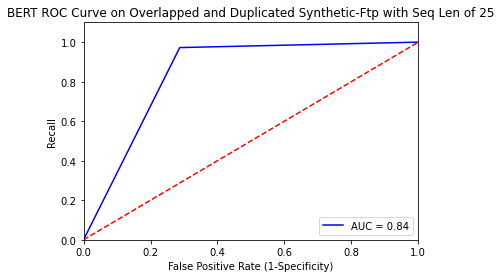

In [37]:
print('----------------------------Evaluating BERT with Clean Data----------------------------')
BERT_clean_perf = get_Bert_performance(clean_test_dataloader, test_clean_y, 0)

----------------------------Evaluating BERT with Unclean Data----------------------------
---------------------Testing BERT with 101% duplication-------------------
Confusion Matrix: 
 [[267 116]
 [  4 151]]

Testing Accuracy: 0.78
Precision:0.57
Recall: 0.97
False Positive Rate: 0.30

Classification report:
              precision    recall  f1-score   support

       False       0.99      0.70      0.82       383
        True       0.57      0.97      0.72       155

    accuracy                           0.78       538
   macro avg       0.78      0.84      0.77       538
weighted avg       0.86      0.78      0.79       538

AUC: 0.84


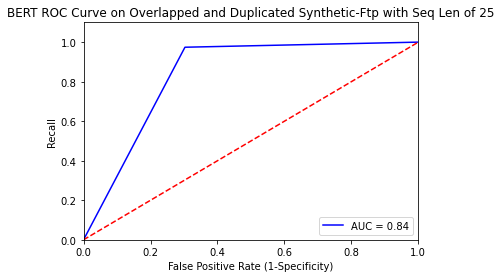

In [38]:
print('----------------------------Evaluating BERT with Unclean Data----------------------------')
BERT_unclean_perf = get_Bert_performance(unclean_test_dataloader, test_unclean_y, 101)

write_to_file(BERT_clean_perf,   'BERT', 'clean')
write_to_file(BERT_unclean_perf, 'BERT', 'unclean')

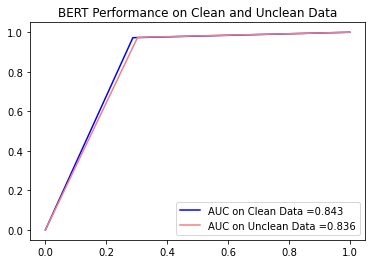

In [39]:
plot_ROC_Clean_Unclean(BERT_clean_perf, BERT_unclean_perf, 'BERT')

In [ ]:
def process_test_texts():
    list_of_text, list_of_labels = [], []
    all_list_of_text, all_list_of_labels = [], []
    file_ind = 0
    # iterate thru ea file, in each record, combine syscalls into a sequence separated by " "
    for f in test_files:
        label = f['Label']; data = f.drop(columns=['Label'])
        text = []  # reset text from each file 
        for i in range(data.shape[0]):
            text.append(" ".join(np.array(data.iloc[i,:]).astype(str)))
        list_of_text.append( tuple(text)  ) # ea element in list_of_text is a test file
        list_of_labels.append(np.array(label.tolist()) == 1) # ea element in list_of_labels is the labels in a test file
        #print('File index', file_ind, ' has len: ',len(list_of_text[file_ind])) # len of each test file
        file_ind += 1
    
    tokens_from_all_tests = []
    token_ids_from_all_tests = [] ; all_test_mask_tensor = []
    all_test_masks = []; all_test_tokens_tensor = []; all_test_y_tensor = []
    index = 0
    # Iterating thru each test file
    for file in list_of_text:
        #for trace in file:
        #print('Len of file: ', len(file))print('Len of tokens: ', len(tokens))print('Len of token_ids: ', len(token_ids))
        tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], file))
        tokens_from_all_tests.append(tokens)
        
        token_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokens)), maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")
        token_ids_from_all_tests.append(token_ids)   
        
        # To mask the paddings
        test_masks = [[float(i > 0) for i in ii] for ii in token_ids]
        all_test_masks.append(test_masks)
        
        # Convert token ids to tensor 
        test_tokens_tensor = torch.tensor(token_ids)
        all_test_tokens_tensor.append(test_tokens_tensor)
        
        # Convert labels to tensors
        test_y_tensor = torch.tensor(list_of_labels[index].reshape(-1, 1)).float()
        all_test_y_tensor.append(test_y_tensor)
        
        # Convert to tensro for maks
        test_masks_tensor   = torch.tensor(test_masks)
        all_test_mask_tensor.append(test_masks_tensor)
        
        index += 1

    #print(len(tokens_from_all_tests), len(tokens_from_all_tests[0]))

    return all_test_tokens_tensor, all_test_mask_tensor, all_test_y_tensor, list_of_labels
    
all_test_tokens_tensor, all_test_mask_tensor, all_test_y_tensor, list_of_labels = process_test_texts()

In [ ]:
for i in range(len(test_files)):
    # Load Token, token mask and label into Dataloader
    test_dataset   = TensorDataset(all_test_tokens_tensor[i], all_test_mask_tensor[i], all_test_y_tensor[i])
    
    # Define sampler
    test_sampler = SequentialSampler(test_dataset)

    # Defile test data loader
    test_dataloader   = DataLoader(test_dataset,   sampler = test_sampler,   batch_size=128)
    
    #outfile = open(data_dir+'/result/{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
    #outfile.write('---------------------Testing BERT with %d%% duplication-------------------'%dup_order[i])
    #outfile.close()
    
    print('----------------------------Evaluating BERT with %d%% Duplication----------------------------'%dup_order[i])
    BERT_unclean_perf = get_Bert_performance(test_dataloader, list_of_labels[i], dup_order[i])

# **GPT-2**

In [40]:
free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 62% |

GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 27% |


In [41]:
#!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

#from ipywidgets import IntProgress
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

In [42]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

clean_test_texts = []
for i in range(test_clean.shape[0]):
    clean_test_texts.append(" ".join(np.array(test_clean.iloc[i,:]).astype(str)))
clean_test_texts = tuple(clean_test_texts) 

unclean_test_texts = []
for i in range(test_unclean.shape[0]):
     unclean_test_texts.append(" ".join(np.array(test_unclean.iloc[i,:]).astype(str)))
unclean_test_texts = tuple(unclean_test_texts) 

train_labels        = tuple(y_train.tolist())
clean_test_labels   = tuple(y_test_clean.tolist())
unclean_test_labels = tuple(y_test_unclean.tolist())

# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_clean_y = np.array(clean_test_labels) == 1
test_unclean_y = np.array(unclean_test_labels) == 1


# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens        = tokenizer(train_texts,      return_tensors='pt',  truncation=True,  padding=True,  max_length = SEQ_WINDOW)
clean_test_tokens   = tokenizer(clean_test_texts, return_tensors='pt',  truncation=True,  padding=True,  max_length = SEQ_WINDOW)
unclean_test_tokens = tokenizer(unclean_test_texts,return_tensors='pt', truncation=True,  padding=True,  max_length = SEQ_WINDOW)


In [43]:
train_tokens

{'input_ids': tensor([[ 3134,  8275,  8275,  ...,  4153,  4153, 15696],
        [   21,  1160,  5598,  ...,  8275,  8275,  8275],
        [ 3134,  8275, 19710,  ..., 16226, 16226, 16226],
        ...,
        [15801, 15696, 15696,  ...,   604,   513,   604],
        [ 2231, 15495,  4153,  ...,  9919,  9919,  9919],
        [15801,   642,  5996,  ...,  9919,  9919,  9919]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [44]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids        = train_tokens.input_ids
clean_test_tokens_ids   = clean_test_tokens.input_ids
unclean_test_tokens_ids = unclean_test_tokens.input_ids

train_tokens_ids.shape, clean_test_tokens_ids.shape, unclean_test_tokens_ids.shape

(torch.Size([252440, 25]), torch.Size([493, 25]), torch.Size([538, 25]))

In [45]:
train_masks        = train_tokens.attention_mask
clean_test_masks   = clean_test_tokens.attention_mask
unclean_test_masks = unclean_test_tokens.attention_mask

**Create GPT-2 Classifer**

In [46]:
class GPT2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GPT2BinaryClassifier, self).__init__()
        self.gpt2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gpt2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gpt2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gpt2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gpt2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gpt2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [47]:
torch.cuda.empty_cache() # free cuda memory to avoid cuda out of mem

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt_clf = GPT2BinaryClassifier()
gpt_clf = gpt_clf.cuda()


Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Configure the Padding token id
gpt_clf.gpt2.config.pad_token_id = tokenizer.eos_token_id
gpt_clf.train_m(train_tokens_ids,train_y,train_masks, EPOCHS, BATCH_SZ)

Epoch:  2
7888/7888.75 loss: 0.17493416187598984 


In [49]:
if CLEAN is True: clean_status = 'clean'
else:             clean_status = 'unclean'

# Save model
torch.save(gpt_clf, data_dir+'/saved_models/GPT{}'.format(clean_status))

#Load model
gpt_clf = torch.load(data_dir+'/saved_models/GPT{}'.format(clean_status))

**Evaluate on Testing Set**

In [50]:
# Copy construct from token ids
clean_test_tokens_tensor   = clean_test_tokens_ids.clone().detach()   #torch.tensor(clean_test_tokens_ids)
unclean_test_tokens_tensor = unclean_test_tokens_ids.clone().detach() #torch.tensor(unclean_test_tokens_ids)
clean_test_y_tensor   = torch.tensor(test_clean_y.reshape(-1, 1)).long()
unclean_test_y_tensor = torch.tensor(test_unclean_y.reshape(-1, 1)).long()

clean_test_masks_tensor   = clean_test_masks.clone().detach()  #torch.tensor(clean_test_masks)
unclean_test_masks_tensor = unclean_test_masks.clone().detach()  #torch.tensor(unclean_test_masks)


clean_test_dataset   = TensorDataset(clean_test_tokens_tensor, clean_test_masks_tensor, clean_test_y_tensor)
unclean_test_dataset = TensorDataset(unclean_test_tokens_tensor, unclean_test_masks_tensor, unclean_test_y_tensor)

clean_test_sampler = SequentialSampler(clean_test_dataset)
unclean_test_sampler = SequentialSampler(unclean_test_dataset)

clean_test_dataloader = DataLoader(clean_test_dataset,     sampler= clean_test_sampler,   batch_size=128)
unclean_test_dataloader = DataLoader(unclean_test_dataset, sampler= unclean_test_sampler, batch_size=128)


In [51]:
# Evaluate Model
def evaluate_GPT(dataloader):
  gpt_clf.eval() # Define eval
  gpt_predicted = [] # Store Result
  with torch.no_grad():
      for step_num, batch_data in enumerate(dataloader):

          token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

          # ----------------------------------------------------------------
          outputs = gpt_clf.gpt2(token_ids,attention_mask=masks,labels=labels)
          loss, logits = outputs[:2]
          numpy_logits = logits.detach().cpu().numpy()
          # ----------------------------------------------------------------
          gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())
  return gpt_predicted


def get_GPT_performance(dataloader, label, dup_status):
  gpt_predicted = evaluate_GPT(dataloader)
  outfile = open(data_dir+'/result/{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
  outfile.write('---------------------Testing GPT with %d%% duplication-------------------'% dup_status)
  outfile.close()
    
  print('---------------------Testing GPT with %d%% duplication-------------------'% dup_status)  
  print_performance('GPT', label, gpt_predicted, dup_status)

  # Recording TPR and FPR for the TESTING-ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, gpt_predicted)
  performance['auc'] = roc_auc_score(label, gpt_predicted)
  return performance

----------------------------Evaluating GPT with Clean Data----------------------------
---------------------Testing GPT with 0% duplication-------------------
Confusion Matrix: 
 [[294  54]
 [  2 143]]

Testing Accuracy: 0.89
Precision:0.73
Recall: 0.99
False Positive Rate: 0.16

Classification report:
              precision    recall  f1-score   support

       False       0.99      0.84      0.91       348
        True       0.73      0.99      0.84       145

    accuracy                           0.89       493
   macro avg       0.86      0.92      0.87       493
weighted avg       0.91      0.89      0.89       493

AUC: 0.92


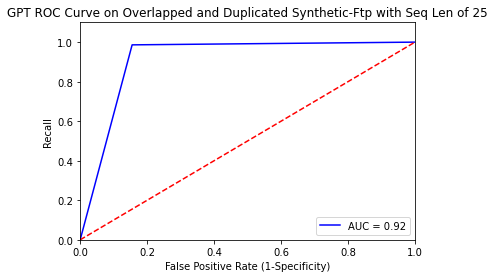

In [52]:
print('----------------------------Evaluating GPT with Clean Data----------------------------')
GPT_clean_perf = get_GPT_performance(clean_test_dataloader, test_clean_y, 0)

----------------------------Evaluating GPT with Unclean Data----------------------------
---------------------Testing GPT with 101% duplication-------------------
Confusion Matrix: 
 [[313  70]
 [  2 153]]

Testing Accuracy: 0.87
Precision:0.69
Recall: 0.99
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

       False       0.99      0.82      0.90       383
        True       0.69      0.99      0.81       155

    accuracy                           0.87       538
   macro avg       0.84      0.90      0.85       538
weighted avg       0.91      0.87      0.87       538

AUC: 0.90


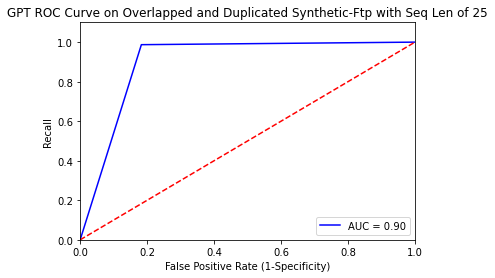

In [53]:
print('----------------------------Evaluating GPT with Unclean Data----------------------------')
GPT_unclean_perf = get_GPT_performance(unclean_test_dataloader, test_unclean_y, 101)

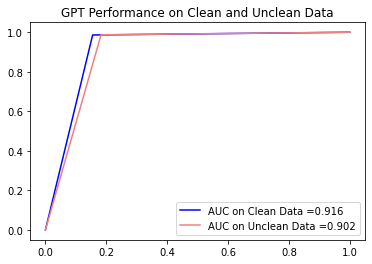

In [54]:
#plot_ROC_Clean_Unclean(BERT_clean_perf, BERT_unclean_perf, 'BERT')
plot_ROC_Clean_Unclean(GPT_clean_perf, GPT_unclean_perf, 'GPT')


In [ ]:
def process_gpt_test_texts():
    list_of_text, list_of_labels = [], []
    all_list_of_text, all_list_of_labels = [], []
    file_ind = 0
    # iterate thru ea file, in each record, combine syscalls into a sequence separated by " "
    for f in test_files:
        label = f['Label']; data = f.drop(columns=['Label'])
        text = []  # reset text from each file 
        for i in range(data.shape[0]):
            text.append(" ".join(np.array(data.iloc[i,:]).astype(str)))
        list_of_text.append( tuple(text)  ) # ea element in list_of_text is a test file
        list_of_labels.append(np.array(label.tolist()) == 1) # ea element in list_of_labels is the labels in a test file
        #print('File index', file_ind, ' has len: ',len(list_of_text[file_ind])) # len of each test file
        file_ind += 1
        
    tokens_from_all_tests = []
    token_ids_from_all_tests = [] ; all_test_mask_tensor = []
    all_test_masks = []; all_test_tokens_tensor = []; all_test_y_tensor = []
    index = 0
    # Iterating thru each test file
    for file in list_of_text:
        tokenizer.padding_side = "right"
        tokenizer.pad_token = tokenizer.eos_token
        tokens        = tokenizer(file,return_tensors='pt',  truncation=True,  padding=True,  max_length = SEQ_WINDOW)
        tokens_from_all_tests.append(tokens)
        
        tokens_ids        = tokens.input_ids
        token_ids_from_all_tests.append(tokens_ids)   
    
          # To mask the paddings
        masks        = tokens.attention_mask
        all_test_masks.append(masks)
        
          # Copy construct from token ids
        tokens_tensor   = tokens_ids.clone().detach() 
        all_test_tokens_tensor.append(tokens_tensor)
        
        
        test_y_tensor   = torch.tensor(list_of_labels[index].reshape(-1, 1)).long()
        all_test_y_tensor.append(test_y_tensor)
        
        masks_tensor   = masks.clone().detach() 
        all_test_mask_tensor.append(masks_tensor)
        
        
        index += 1
    #print(len(tokens_from_all_tests), len(tokens_from_all_tests[0]))

    return all_test_tokens_tensor, all_test_mask_tensor, all_test_y_tensor, list_of_labels

all_test_tokens_tensor, all_test_mask_tensor, all_test_y_tensor, list_of_labels = process_gpt_test_texts()

In [ ]:
for i in range(len(test_files)):
    
    #----------------------------------
    # Load Token, token mask and label into Dataloader
    test_dataset   = TensorDataset(all_test_tokens_tensor[i], all_test_mask_tensor[i], all_test_y_tensor[i])

    # Define sampler
    test_sampler = SequentialSampler(test_dataset)

    # Defile test data loader
    test_dataloader   = DataLoader(test_dataset,   sampler = test_sampler,   batch_size=128)
    
    #outfile = open('{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
    #outfile.write('---------------------Testing GPT with %d%% duplication-------------------'%dup_order[i])
    #outfile.close()
    
    print('----------------------------Evaluating GPT with %d%% Duplication----------------------------'%dup_order[i])
    GPT_unclean_perf = get_GPT_performance(test_dataloader, list_of_labels[i], dup_order[i])

# **Write performance measures to file**

In [ ]:
write_to_file(GPT_clean_perf,   'GPT', 'clean')
write_to_file(GPT_unclean_perf, 'GPT', 'unclean')